<a href="https://colab.research.google.com/github/nikhilbansal23/FlaggingLoans/blob/main/Flagging_Loans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import uuid
from datetime import datetime
from scipy.stats import norm
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
import plotly.graph_objs as go
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
import plotly.figure_factory as ff


In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

In [3]:
import warnings

warnings.filterwarnings("ignore")

In [4]:
#importing datasets
df = pd.read_csv('/content/drive/MyDrive/Datasets/Flagging Bad Loans/test_task.csv')

# Data Exploration

In [5]:
df.head()

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,NaN,NaN,NaN,NaN,3.0,region_6,6,0,0,10,0,0,0,10.0,NaN,NaN,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,0,0,6,0,0,0,5.0,NaN,NaN,20.0,False,0
2,779736,2016-10-30,2015-12-21,NaN,NaN,NaN,NaN,2.0,region_1,6,0,0,0,5,0,0,5.0,NaN,NaN,19.0,False,0
3,556376,2016-06-29,2015-06-30,NaN,NaN,NaN,NaN,1.0,region_6,14,0,0,4,0,0,0,6.0,NaN,NaN,21.0,False,0
4,266968,2015-12-01,2015-08-03,NaN,NaN,NaN,NaN,0.0,region_5,22,0,3,0,0,0,0,3.0,NaN,NaN,33.0,False,0


In [6]:
df[[
    "dpd_5_cnt",
    "dpd_15_cnt",
    "dpd_30_cnt",
    "close_loans_cnt",
    "payment_type_0",
    "payment_type_1",
    "payment_type_2",
    "payment_type_3",
    "payment_type_4",
    "payment_type_5",
    "past_billings_cnt",
    "score_1",
    "score_2",
    "age"
]].describe()

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age
count,675.000000,675.000000,675.000000,4142.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.000000,4157.0,3909.000000,3507.000000,239.000000,4157.000000
mean,1.444444,0.733333,0.280000,1.184693,0.018523,0.596103,3.755834,0.758239,0.019485,0.0,4.979023,578.911345,552.546610,34.561222
std,0.900599,0.764572,0.502339,1.723715,0.330359,2.564887,3.810703,2.212487,0.245960,0.0,3.491556,48.989869,21.492840,10.834143
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,384.220628,485.874267,18.000000
25%,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.0,2.000000,547.429791,535.545724,26.000000
50%,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,3.000000,0.000000,0.000000,0.0,4.000000,588.531315,556.757944,32.000000
75%,2.000000,1.000000,1.000000,2.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.0,6.000000,612.323090,567.608057,41.000000
max,7.000000,5.000000,3.000000,31.000000,15.000000,81.000000,33.000000,35.000000,7.000000,0.0,21.000000,691.528420,603.311653,74.000000


In [7]:
# next, we 'describe' the categorical columns
# note that the output differs between the two calls to `.describe()`
df[[
    "federal_district_nm",
    "gender"
]].describe()

,federal_district_nm,gender
count,4146,4157
unique,8,2
top,region_3,False
freq,1595,3570


## Missing Data Check

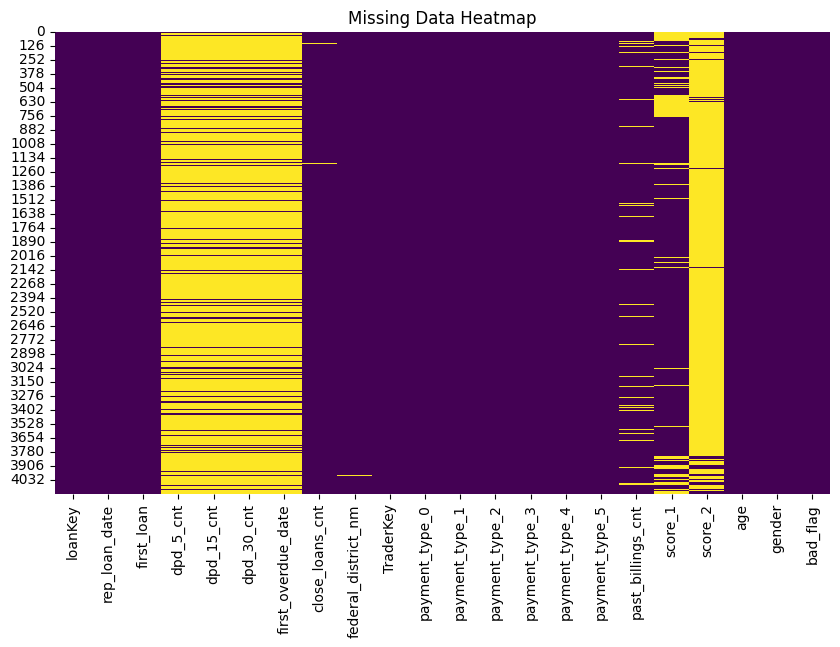

In [8]:
# Check for missing data using heatmap. Looks like we are good to go with missing data handling
missing_data = df.isnull().sum()

# Visualize missing data
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Data Heatmap')
plt.show()

In [9]:
# Identify columns ending with '_datetime' and convert them to datetime dtype
datetime_columns = [col for col in df.columns if col.endswith('_date')]
df[datetime_columns] = df[datetime_columns].apply(pd.to_datetime)
df['first_loan'] = df['first_loan'].apply(pd.to_datetime)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4157 entries, 0 to 4156
Data columns (total 22 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   loanKey              4157 non-null   int64         
 1   rep_loan_date        4157 non-null   datetime64[ns]
 2   first_loan           4157 non-null   datetime64[ns]
 3   dpd_5_cnt            675 non-null    float64       
 4   dpd_15_cnt           675 non-null    float64       
 5   dpd_30_cnt           675 non-null    float64       
 6   first_overdue_date   675 non-null    datetime64[ns]
 7   close_loans_cnt      4142 non-null   float64       
 8   federal_district_nm  4146 non-null   object        
 9   TraderKey            4157 non-null   int64         
 10  payment_type_0       4157 non-null   int64         
 11  payment_type_1       4157 non-null   int64         
 12  payment_type_2       4157 non-null   int64         
 13  payment_type_3       4157 non-nul

In [11]:
len(df)

4157

In [12]:
df['gender'].value_counts()

False    3570
True      587
Name: gender, dtype: int64

In [13]:
#cool method to handle null values
def handle_nulls_by_dtype(dataframe, inplace=True):
    for col in dataframe.columns:
        dtype = dataframe[col].dtype
        if pd.api.types.is_numeric_dtype(dtype):
            # Fill null values in numeric columns (including int and float) with 0
            dataframe[col] = dataframe[col].fillna(0)
        elif pd.api.types.is_datetime64_any_dtype(dtype):
            # Fill null values in datetime columns with a specific date (e.g., '2023-01-01')
            dataframe[col] = dataframe[col].fillna(pd.to_datetime('2099-01-01'))
        elif pd.api.types.is_string_dtype(dtype):
            # Fill null values in string columns with a specific value (e.g., 'Unknown')
            dataframe[col] = dataframe[col].fillna('Unknown')
        # Handling integer columns separately
        elif pd.api.types.is_integer_dtype(dtype):
            # Fill null values in integer columns with 0
            dataframe[col] = dataframe[col].fillna(0)

In [14]:
handle_nulls_by_dtype(df)

In [15]:
null_perc = df.isnull().mean() * 100
null_perc

loanKey                0.0
rep_loan_date          0.0
first_loan             0.0
dpd_5_cnt              0.0
dpd_15_cnt             0.0
dpd_30_cnt             0.0
first_overdue_date     0.0
close_loans_cnt        0.0
federal_district_nm    0.0
TraderKey              0.0
payment_type_0         0.0
payment_type_1         0.0
payment_type_2         0.0
payment_type_3         0.0
payment_type_4         0.0
payment_type_5         0.0
past_billings_cnt      0.0
score_1                0.0
score_2                0.0
age                    0.0
gender                 0.0
bad_flag               0.0
dtype: float64

In [16]:
df.head(10)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag
0,708382,2016-10-06,2015-11-13,0.0,0.0,0.0,2099-01-01,3.0,region_6,6,0,0,10,0,0,0,10.0,0.0,0.0,21.0,False,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,0,0,6,0,0,0,5.0,0.0,0.0,20.0,False,0
2,779736,2016-10-30,2015-12-21,0.0,0.0,0.0,2099-01-01,2.0,region_1,6,0,0,0,5,0,0,5.0,0.0,0.0,19.0,False,0
3,556376,2016-06-29,2015-06-30,0.0,0.0,0.0,2099-01-01,1.0,region_6,14,0,0,4,0,0,0,6.0,0.0,0.0,21.0,False,0
4,266968,2015-12-01,2015-08-03,0.0,0.0,0.0,2099-01-01,0.0,region_5,22,0,3,0,0,0,0,3.0,0.0,0.0,33.0,False,0
5,697186,2016-10-01,2015-08-30,0.0,0.0,0.0,2099-01-01,2.0,region_3,38,0,0,6,0,0,0,5.0,0.0,0.0,34.0,False,0
6,347907,2016-02-18,2015-06-07,1.0,0.0,0.0,2015-11-06,2.0,region_3,6,0,0,9,0,0,0,8.0,0.0,0.0,32.0,False,0
7,256097,2015-11-23,2015-06-04,1.0,1.0,0.0,2015-11-06,0.0,region_3,6,0,0,5,0,0,0,5.0,0.0,0.0,23.0,False,1
8,670540,2016-09-19,2015-12-03,3.0,1.0,0.0,2016-01-15,1.0,region_2,6,0,0,4,0,0,0,6.0,0.0,0.0,33.0,False,0
9,254453,2015-11-22,2015-06-04,1.0,1.0,0.0,2015-11-06,0.0,region_3,6,0,0,5,0,0,0,5.0,0.0,0.0,23.0,False,1


# Data Visualization

In [17]:
# Group by 'host_id' and calculate total earnings for each host

bad_flag = df.groupby('bad_flag')['loanKey'].count().reset_index()
bad_flag = bad_flag.rename(columns={'loanKey': 'count'})

sorted = bad_flag.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted, x='bad_flag', y='count', title='Bad Loan Flags',
             labels={'bad_flag': 'Bad Loan Flags', 'count': 'Volume'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [18]:
df_bad = df[df['bad_flag']== 1]

In [19]:
# Group by 'host_id' and calculate total earnings for each host

federal_district_nm = df_bad.groupby('federal_district_nm')['loanKey'].count().reset_index()
federal_district_nm = federal_district_nm.rename(columns={'loanKey': 'count'})

sorted = federal_district_nm.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted, x='federal_district_nm', y='count', title='Federal District Regions',
             labels={'federal_district_nm': 'Regions', 'count': 'Volume'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


In [20]:
# Group by 'host_id' and calculate total earnings for each host

gender = df_bad.groupby('gender')['loanKey'].count().reset_index()
gender = gender.rename(columns={'loanKey': 'count'})

sorted = gender.sort_values(by='count', ascending=False)
# Plot the bar chart for top hosts with most earnings
fig = px.bar(sorted, x='gender', y='count', title='Gender',
             labels={'gender': 'Gender', 'count': 'Volume'}, height=400)
fig.update_xaxes(type='category')  # Set x-axis type to category
fig.show()


## Time Series Analysis - Delinquency Trends Over Time

In [21]:
import plotly.express as px

# Time Series - Delinquency Trends Over Time
time_series_data = df[['rep_loan_date', 'dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']]
time_series_data['rep_loan_date'] = pd.to_datetime(time_series_data['rep_loan_date'])

fig = px.line(time_series_data, x='rep_loan_date', y=['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt'], title='Delinquency Trends Over Time')
fig.show()


## Loan Distribution - Histograms

In [22]:
# Loan Distribution - Histograms
histogram_data = df[['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt']]
fig = px.histogram(histogram_data, histnorm='percent')
fig.update_layout(barmode='overlay', title='Loan Delinquency Distribution')
fig.show()

## Age and Gender Analysis - Boxplot

In [23]:
# Age and Gender Analysis - Boxplot
age_gender_data = df[['age', 'gender', 'bad_flag']]
fig = px.box(age_gender_data, x='gender', y='age', color='bad_flag', title='Age Distribution by Gender and Loan Default')
fig.show()


## Loan Aging Analysis - Scatter Plot

In [24]:
# Loan Aging Analysis - Scatter Plot
aging_data = df[['first_loan', 'first_overdue_date']]
aging_data['first_loan'] = pd.to_datetime(aging_data['first_loan'])
aging_data['first_overdue_date'] = pd.to_datetime(aging_data['first_overdue_date'])

fig = px.scatter(aging_data, x='first_loan', y='first_overdue_date', title='Loan Aging Analysis')
fig.show()


## Payment Type Analysis - Bar Chart

In [25]:
# Payment Type Analysis - Bar Chart
payment_types_data = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4', 'payment_type_5']]
payment_types_counts = payment_types_data.sum()

fig = px.bar(x=payment_types_counts.index, y=payment_types_counts.values, title='Payment Types Distribution')
fig.show()


## Correlation Heatmap

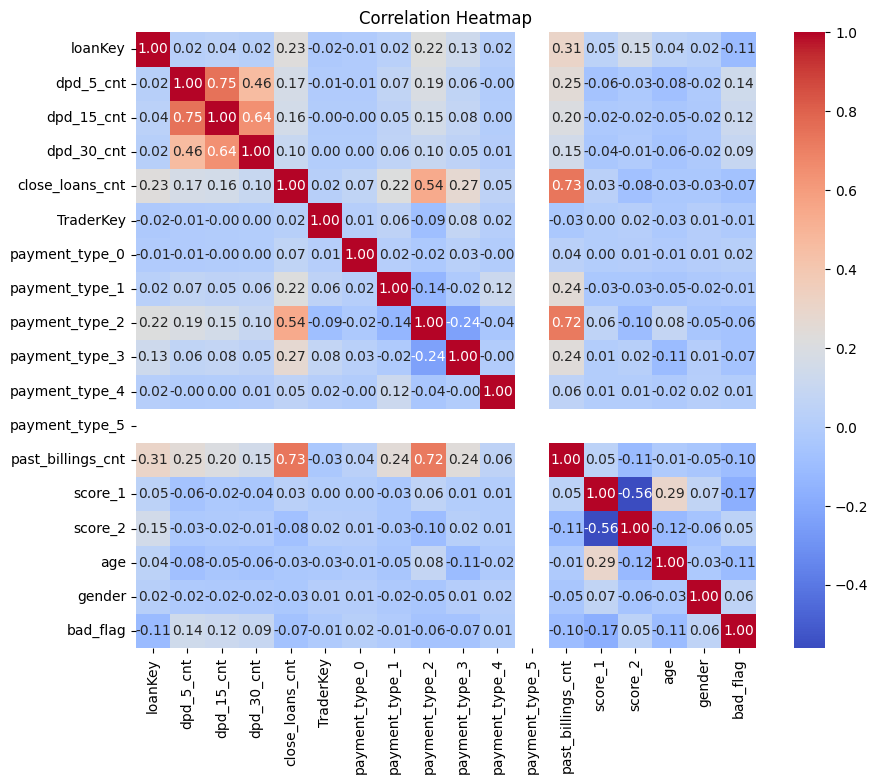

In [26]:
# Correlation Heatmap
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


## Correlation Matrix with 'bad_flag'

In [27]:
# Correlation Matrix with 'bad_flag'
correlation_with_bad_flag = df.corr()['bad_flag'].sort_values(ascending=False)
correlation_with_bad_flag = correlation_with_bad_flag.drop('bad_flag')  # Drop self-correlation
correlation_with_bad_flag = correlation_with_bad_flag.abs()  # Take absolute values for magnitude

fig = px.bar(x=correlation_with_bad_flag.index, y=correlation_with_bad_flag.values, title='Correlation with Bad Flag')
fig.update_traces(marker_color='orange', marker_line_color='black', marker_line_width=1)
fig.show()


# Feature Engineering

In [28]:
# Convert boolean column to numeric (1 and 0)
df['bad_flag'] = df['bad_flag'].astype(int)
df['gender'] = df['gender'].astype(int)
df['age'] = df['age'].astype(int)
df["days_between_rep_and_first_loan"] = (df["rep_loan_date"] - df["first_loan"]).dt.days

In [29]:
import pandas as pd

bins = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]  # Define bins for decades

# Creating labels for the bins with a prefix
labels = ['Age_0-9', 'Age_10-19', 'Age_20-29', 'Age_30-39', 'Age_40-49', 'Age_50-59', 'Age_60-69', 'Age_70-79', 'Age_80-89', 'Age_90-100']

# Applying binning to the 'age' column
df['age_decade'] = pd.cut(df['age'], bins=bins, labels=labels, right=False)



In [30]:
federal_districts = pd.get_dummies(df["federal_district_nm"], prefix="federal")

In [31]:
age_segg = pd.get_dummies(df["age_decade"])

In [32]:
df = pd.concat(objs=[df, federal_districts,age_segg], axis=1)

In [33]:
# df.info()

In [34]:
df.head(2)

,loanKey,rep_loan_date,first_loan,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,first_overdue_date,close_loans_cnt,federal_district_nm,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,age,gender,bad_flag,days_between_rep_and_first_loan,age_decade,federal_Unknown,federal_region_0,federal_region_1,federal_region_2,federal_region_3,federal_region_4,federal_region_5,federal_region_6,federal_region_7,Age_0-9,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79,Age_80-89,Age_90-100
0,708382,2016-10-06,2015-11-13,0.0,0.0,0.0,2099-01-01,3.0,region_6,6,0,0,10,0,0,0,10.0,0.0,0.0,21,0,0,328,Age_20-29,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,406305,2016-03-26,2015-09-28,1.0,0.0,0.0,2016-01-30,0.0,region_6,6,0,0,6,0,0,0,5.0,0.0,0.0,20,0,0,180,Age_20-29,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [35]:
cols_drop = ['age_decade','federal_Unknown','federal_district_nm','first_loan','loanKey','rep_loan_date','first_overdue_date','age']

df_cleaned = df.drop(df[cols_drop],axis = 1)

In [36]:
df_cleaned.columns

Index(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt', 'TraderKey',
       'payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3',
       'payment_type_4', 'payment_type_5', 'past_billings_cnt', 'score_1',
       'score_2', 'gender', 'bad_flag', 'days_between_rep_and_first_loan',
       'federal_region_0', 'federal_region_1', 'federal_region_2',
       'federal_region_3', 'federal_region_4', 'federal_region_5',
       'federal_region_6', 'federal_region_7', 'Age_0-9', 'Age_10-19',
       'Age_20-29', 'Age_30-39', 'Age_40-49', 'Age_50-59', 'Age_60-69',
       'Age_70-79', 'Age_80-89', 'Age_90-100'],
      dtype='object')

In [37]:
# Correlation Matrix with 'bad_flag'
correlation_with_bad_flag = df_cleaned.corr()['bad_flag'].sort_values(ascending=False)
correlation_with_bad_flag = correlation_with_bad_flag.drop('bad_flag')  # Drop self-correlation
correlation_with_bad_flag = correlation_with_bad_flag.abs()  # Take absolute values for magnitude

fig = px.bar(x=correlation_with_bad_flag.index, y=correlation_with_bad_flag.values, title='Correlation with Bad Flag')
fig.update_traces(marker_color='orange', marker_line_color='black', marker_line_width=1)
fig.show()


In [38]:
df_cleaned['Age_0-9'].value_counts()

0    4157
Name: Age_0-9, dtype: int64

In [39]:
cols = ['Age_0-9','Age_80-89','Age_90-100']
df_cleaned = df_cleaned.drop(df_cleaned[cols],axis = 1)

In [40]:
df_cleaned.head(2)

,dpd_5_cnt,dpd_15_cnt,dpd_30_cnt,close_loans_cnt,TraderKey,payment_type_0,payment_type_1,payment_type_2,payment_type_3,payment_type_4,payment_type_5,past_billings_cnt,score_1,score_2,gender,bad_flag,days_between_rep_and_first_loan,federal_region_0,federal_region_1,federal_region_2,federal_region_3,federal_region_4,federal_region_5,federal_region_6,federal_region_7,Age_10-19,Age_20-29,Age_30-39,Age_40-49,Age_50-59,Age_60-69,Age_70-79
0,0.0,0.0,0.0,3.0,6,0,0,10,0,0,0,10.0,0.0,0.0,0,0,328,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0
1,1.0,0.0,0.0,0.0,6,0,0,6,0,0,0,5.0,0.0,0.0,0,0,180,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0


In [41]:
df_cleaned['dpd_5_cnt'] = df_cleaned['dpd_5_cnt'].astype(int)
df_cleaned['dpd_15_cnt'] = df_cleaned['dpd_15_cnt'].astype(int)
df_cleaned['dpd_30_cnt'] = df_cleaned['dpd_30_cnt'].astype(int)
df_cleaned['close_loans_cnt'] = df_cleaned['close_loans_cnt'].astype(int)
df_cleaned['past_billings_cnt'] = df_cleaned['past_billings_cnt'].astype(int)
df_cleaned['score_1'] = df_cleaned['score_1'].astype(int)
df_cleaned['score_2'] = df_cleaned['score_2'].astype(int)


In [42]:
len(df_cleaned.columns)

32

In [43]:
def highly_correlated_columns(df, threshold=0.7):

    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Extract upper triangle of correlation matrix without diagonal
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find column pairs with correlation above the threshold
    highly_correlated = [(col1, col2) for col1 in upper_triangle.columns
                         for col2 in upper_triangle.columns
                         if upper_triangle[col1][col2] > threshold]

    return highly_correlated

In [44]:
correlated_columns = highly_correlated_columns(df_cleaned, threshold=0.7)
print("Highly correlated columns:")
print(correlated_columns)

Highly correlated columns:
[('dpd_15_cnt', 'dpd_5_cnt'), ('past_billings_cnt', 'close_loans_cnt'), ('past_billings_cnt', 'payment_type_2'), ('days_between_rep_and_first_loan', 'past_billings_cnt')]


In [45]:
high_corr_cols = [

                  'dpd_5_cnt', 'past_billings_cnt','payment_type_2'

]

In [46]:
df_cleaned.drop(df_cleaned[high_corr_cols], axis=1, inplace = True)

In [56]:
df_cleaned['bad_flag'].value_counts()

0    3740
1     417
Name: bad_flag, dtype: int64

In [47]:
X = df_cleaned.drop('bad_flag', axis=1)  # Features
y = df_cleaned['bad_flag']  # Target variable

In [57]:
from imblearn.over_sampling import SMOTE

# Assuming X contains your features and y contains your target variable
# X: Features, y: Target variable (0 and 1 for binary classification)

# Instantiate the SMOTE
smote = SMOTE(random_state=42)

# Resample the dataset
X_resampled, y_resampled = smote.fit_resample(X, y)

# Check the class distribution after oversampling
print("After SMOTE:")
print(y_resampled.value_counts())  # Assuming y_resampled is a Pandas Series or similar


After SMOTE:
0    3740
1    3740
Name: bad_flag, dtype: int64


In [59]:
import statsmodels.api as sm
# Add a constant term for the intercept
X_resampled = sm.add_constant(X_resampled)

# Fit the OLS (Ordinary Least Squares) model
model = sm.OLS(y_resampled, X_resampled).fit()

# Get p-values for each feature
p_values = model.pvalues

# Select features based on a threshold (e.g., 0.05)
selected_features = p_values[p_values < 0.05].index.tolist()

# Display selected features
print("Selected Features based on p-value:")
print(selected_features)

Selected Features based on p-value:
['const', 'dpd_15_cnt', 'TraderKey', 'payment_type_0', 'payment_type_3', 'payment_type_5', 'score_1', 'score_2', 'gender', 'days_between_rep_and_first_loan', 'federal_region_0', 'federal_region_1', 'federal_region_2', 'federal_region_3', 'federal_region_4', 'federal_region_5', 'federal_region_6', 'federal_region_7', 'Age_10-19', 'Age_20-29', 'Age_30-39', 'Age_40-49', 'Age_50-59', 'Age_60-69']


In [60]:
features_to_keep = p_values[p_values < 0.05]
X_reduced = X_resampled[features_to_keep.index]
X_reduced = X_reduced.drop('const', axis=1)

In [61]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y_resampled, test_size=0.4, random_state=50)

# Model Building & Evaluation

## Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import precision_score, recall_score, f1_score

# Initialize the Logistic Regression model
logreg = LogisticRegression(max_iter=1000)  # You can adjust parameters as needed

# Train the model
logreg.fit(X_train, y_train)


# Predict on validation set
lg_predictions = logreg.predict(X_test)

# Evaluate model performance
lg_accuracy = accuracy_score(y_test, lg_predictions)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, lg_predictions))

print("Confusion Matrix:")
cm = confusion_matrix(y_test, lg_predictions)

# Create an array to label confusion matrix
class_names = ['bad_flag=0', 'bad_flag=1']  # Replace with your class names if needed

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()



Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.98      0.92      1467
           1       0.98      0.85      0.91      1525

    accuracy                           0.92      2992
   macro avg       0.92      0.92      0.92      2992
weighted avg       0.92      0.92      0.92      2992

Confusion Matrix:


## XG Boost Classifier

In [63]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Create and train the XGBoost model
xgb_model = XGBClassifier()
xgb_model.fit(X_train, y_train)

# Make predictions on the test set
xgb_pred = xgb_model.predict(X_test)


# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, xgb_pred))

print("Confusion Matrix:")
# print(confusion_matrix(y_test, xgb_pred))
cm = confusion_matrix(y_test, xgb_pred)
# Create an array to label confusion matrix
class_names = ['bad_flag=0', 'bad_flag=1']   # Replace with your class names if needed

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.95      0.93      1467
           1       0.95      0.92      0.93      1525

    accuracy                           0.93      2992
   macro avg       0.93      0.93      0.93      2992
weighted avg       0.93      0.93      0.93      2992

Confusion Matrix:


## Random Forrest

In [64]:
from sklearn.ensemble import RandomForestClassifier

# Initialize the model
random_forest = RandomForestClassifier()

# Train the model
random_forest.fit(X_train, y_train)

# Predict on test set
rf_test_predictions = random_forest.predict(X_test)


# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, rf_test_predictions))

print("Confusion Matrix:")
# print(confusion_matrix(y_test, xgb_pred))
cm = confusion_matrix(y_test, rf_test_predictions)
# Create an array to label confusion matrix
class_names = ['bad_flag=0', 'bad_flag=1']   # Replace with your class names if needed

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.96      0.94      1467
           1       0.96      0.92      0.94      1525

    accuracy                           0.94      2992
   macro avg       0.94      0.94      0.94      2992
weighted avg       0.94      0.94      0.94      2992

Confusion Matrix:


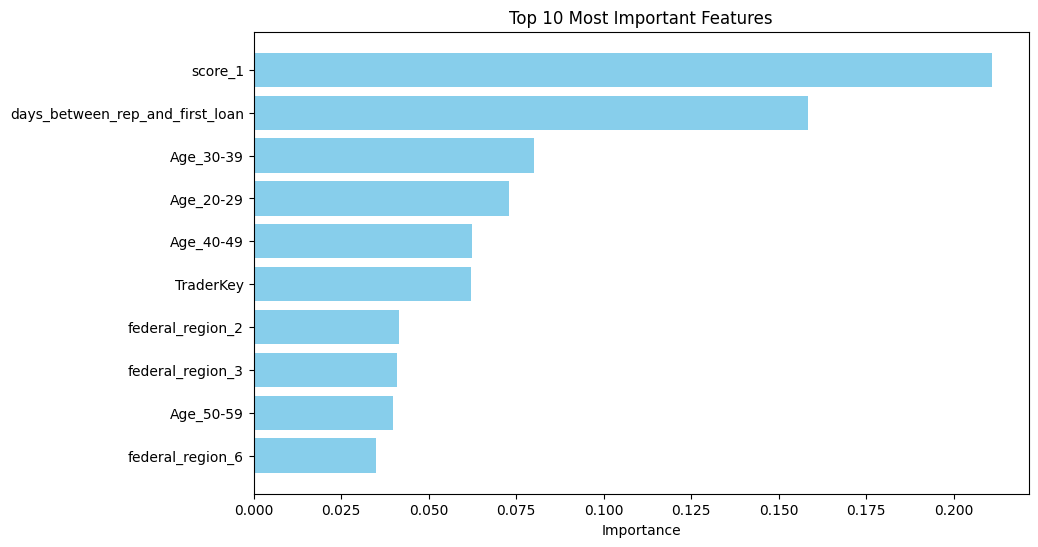

In [67]:

feature_importances = random_forest.feature_importances_

# Create a DataFrame to display feature importances
feature_importance_df = pd.DataFrame({'Feature': X_reduced.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Display the top N most important features (e.g., top 10)
top_n = 10
top_features = feature_importance_df.head(top_n)

# Plotting the feature importances
plt.figure(figsize=(10, 6))
plt.barh(top_features['Feature'], top_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title(f'Top {top_n} Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis for better visualization
plt.show()


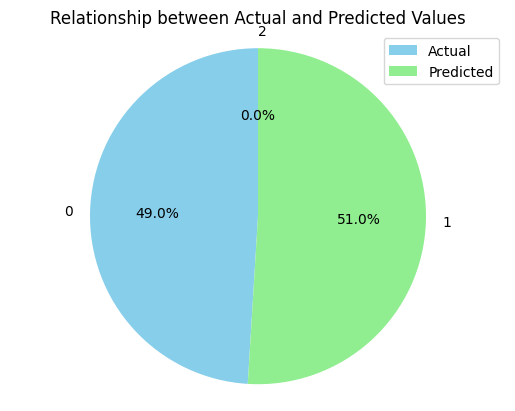

In [69]:
from collections import Counter
# Assuming rf_model is already trained and used to predict values
predicted_values = random_forest.predict(X_test)  # Replace X_test with your test data

# Assuming y_test contains the actual target values
actual_values = y_test  # Replace y_test with your actual target values

# Count occurrences of actual and predicted values
actual_counter = Counter(actual_values)
predicted_counter = Counter(predicted_values)

# Get unique labels (assuming binary classification)
labels = list(set(actual_values + predicted_values))

# Get counts for each label in actual and predicted values
actual_counts = [actual_counter[label] for label in labels]
predicted_counts = [predicted_counter[label] for label in labels]

# Plotting the pie chart
fig, ax = plt.subplots()
ax.pie(actual_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=['skyblue', 'lightgreen'])
ax.axis('equal')  # Equal aspect ratio ensures the pie chart is circular

plt.title('Relationship between Actual and Predicted Values')
plt.legend(['Actual', 'Predicted'], loc='upper right')
plt.show()

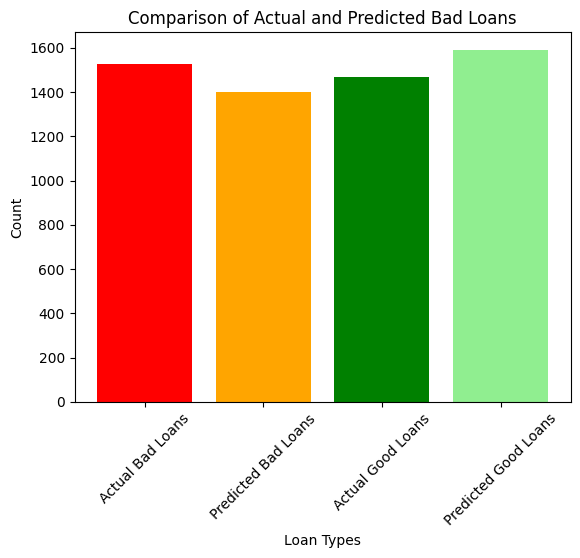

In [71]:
import matplotlib.pyplot as plt

# Assuming you have actual_values and predicted_values from your RF model

# Counting actual bad loans
actual_bad_loans_count = sum(1 for val in actual_values if val == 1)

# Finding indices of predicted bad loans
predicted_bad_loans = [1 for actual, predicted in zip(actual_values, predicted_values) if actual == 1 and predicted == 1]

# Counting predicted bad loans
predicted_bad_loans_count = sum(predicted_bad_loans)

# Counting actual good loans
actual_good_loans_count = len(actual_values) - actual_bad_loans_count

# Counting predicted good loans
predicted_good_loans_count = len(actual_values) - predicted_bad_loans_count

# Plotting the bar chart
labels = ['Actual Bad Loans', 'Predicted Bad Loans', 'Actual Good Loans', 'Predicted Good Loans']
values = [actual_bad_loans_count, predicted_bad_loans_count, actual_good_loans_count, predicted_good_loans_count]

plt.bar(labels, values, color=['red', 'orange', 'green', 'lightgreen'])
plt.xlabel('Loan Types')
plt.ylabel('Count')
plt.title('Comparison of Actual and Predicted Bad Loans')
plt.xticks(rotation=45)
plt.show()


## Decision Tree

In [65]:
from sklearn.tree import DecisionTreeClassifier
# Instantiate Decision Tree Classifier with max leaf nodes = 3
tree_3_leaf = DecisionTreeClassifier(max_leaf_nodes= 3, random_state=2)

# Train the classifier on the training data
tree_3_leaf.fit(X_train, y_train)

# Predict the test data with trained tree classifier
dt_predict = tree_3_leaf.predict(X_test)

# Classification report and confusion matrix
print("Classification Report:")
print(classification_report(y_test, dt_predict))


# print(confusion_matrix(y_test, xgb_pred))
cm = confusion_matrix(y_test, dt_predict)
class_names = ['bad_flag=0', 'bad_flag=1']

# Create a heatmap for the confusion matrix using Plotly
fig = ff.create_annotated_heatmap(
    z=cm,
    x=class_names,
    y=class_names,
    colorscale='Blues',
    showscale=True
)

# Add title and labels
fig.update_layout(
    title='Confusion Matrix',
    xaxis=dict(title='Predicted label'),
    yaxis=dict(title='True label')
)

fig.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.83      0.73      1467
           1       0.78      0.57      0.66      1525

    accuracy                           0.70      2992
   macro avg       0.72      0.70      0.70      2992
weighted avg       0.72      0.70      0.69      2992

